# Projekt 3 - Eksperymenty i analiza danych
## Autorzy
- Daniel Zdancewicz [145317]
- Alex Terentowicz [145419]

## Opis

Projekt polega na przeprowadzeniu eksperymentów z użyciem kilku metod i przeprowadzeniu analizy uzyskanych wyników.
Należało odnaleźć zbiór danych, który zawiera kilka kryteriów monotonicznych, ponad 100 alternatyw i co najmniej 2 klasy (jeśli problem ma więcej klas, możesz je zbinaryzować).

Krótko opisz zbiór danych, w tym opisy kryteriów. Dla tego zbioru danych wytrenuj następujące modele:
- Jeden prosty, interpretowalny model ML (np. XGBoost, rankSVM lub regresja logistyczna)
- Jeden interpretowalny model ANN-MCDA przedstawiony na zajęciach (ANN-Ch-Constr. lub ANN-UTADIS)
- Złożony model sici neuronowej zawierającej kilka warstw ukrytych.


## Opis zbioru danych

W tej pracy wybrany zbiór zawierający dane o udzielonych kredytach. Zbiór zawiera 614 rekordów, 13 kolumn i 2 klasy. Kolumny to:
- Loan_ID — Identyfikator udzielonego kredytu
- Gender — Płeć kredytobiorcy
- Married — Stan cywilny kredytobiorcy
- Dependents — Liczba osób na utrzymaniu kredytobiorcy
- Education — Wykształcenie kredytobiorcy
- Self_Employed — Czy kredytobiorca jest samozatrudniony
- ApplicantIncome — Miesięczny dochód kredytobiorcy
- CoapplicantIncome — Miesięczny dochód współkredytobiorcy
- LoanAmount — Kwota kredytu
- Loan_Amount_Term — Okres spłaty kredytu w miesiącach
- Credit_History — Historia kredytowa kredytobiorcy
- Property_Area — Lokalizacja nieruchomości kredytobiorcy
- Loan_Status — Czy kredyt został spłacony

Źródło danych — [Kaggle](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset)

Jako kryteria monotoniczne wybrano:
- ApplicantIncome
- CoapplicantIncome
- LoanAmount
- Loan_Amount_Term

Jako kryteria niemonotoniczne wybrano:
- Gender
- Married
- Dependents
- Education
- Self_Employed
- Credit_History
- Property_Area

Jako klasy wybrano kolumnę Loan_Status, która zawiera informacje o tym czy kredyt został spłacony:
- Y — Kredyt został spłacony
- N — Kredyt nie został spłacony


### Opisy kryteriów


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from pandas import DataFrame

def load() -> tuple[DataFrame, DataFrame]:
  return tuple([pd.read_csv(f"./resources/datasets/loan_sanction_{type_}.csv") for type_ in ["train", "test"]])


In [49]:
train, test = load()

train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [50]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Preprocessing

In [51]:
str_cols = ["Gender", "Married", "Education", "Dependents", "Self_Employed", "Property_Area"]
for col in str_cols:
  print(f"{col}: {train[col].unique()}")

Gender: ['Male' 'Female' nan]
Married: ['No' 'Yes' nan]
Education: ['Graduate' 'Not Graduate']
Dependents: ['0' '1' '2' '3+' nan]
Self_Employed: ['No' 'Yes' nan]
Property_Area: ['Urban' 'Rural' 'Semiurban']


In [53]:
from sklearn.preprocessing import LabelEncoder

encoded_cols = ["Gender", "Married", "Education", "Self_Employed"]

encode_map = {
    "Dependents": {
      "0": 0,
      "1": 1,
      "2": 2,
      "3+": 3
    },
    "Property_Area": {
      "Rural": 0,
      "Semiurban": 1,
      "Urban": 2
    }
  }

def preprocess(df):
  df = df.copy()
  df = df.dropna()
  # kolumna znajduje sie tylko w train:
  cols = encoded_cols if "Loan_Status" not in df.columns else encoded_cols + ["Loan_Status"]
  df[cols] = df[cols].apply(LabelEncoder().fit_transform)
  # encode with custom mapping from dict
  df = df.replace(encode_map)
  # df = drop_outliers(df)
  return df

def drop_ids_and_map(df):
  # create map of loan_id to index
  df_map = dict(zip(df["Loan_ID"], df.index))
  df = df.drop(columns=["Loan_ID"])
  return df, df_map

train, test = (preprocess(df) for df in [train, test])
(train, train_map), (test, test_map) = (drop_ids_and_map(df) for df in [train, test])
train.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.202083,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,0.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [54]:
train.iloc[train_map["LP001003"]]

Gender                  1.0
Married                 1.0
Dependents              0.0
Education               0.0
Self_Employed           1.0
ApplicantIncome      3000.0
CoapplicantIncome       0.0
LoanAmount             66.0
Loan_Amount_Term      360.0
Credit_History          1.0
Property_Area           2.0
Loan_Status             1.0
Name: 2, dtype: float64

In [61]:
cor = train.corr()
cor.mask(np.abs(cor) < 0.1, None)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.349424,0.217510,NaN,NaN,NaN,0.156171,NaN,NaN,NaN,NaN,NaN
Married,0.349424,1.000000,0.386367,NaN,NaN,NaN,0.102950,0.183442,-0.107504,NaN,NaN,0.112321
Dependents,0.217510,0.386367,1.000000,NaN,NaN,0.131139,NaN,0.172780,NaN,NaN,NaN,NaN
Education,NaN,NaN,NaN,1.000000,NaN,-0.131172,NaN,-0.172780,-0.102168,NaN,NaN,NaN
Self_Employed,NaN,NaN,NaN,NaN,1.000000,0.170785,NaN,0.120389,NaN,NaN,NaN,NaN
ApplicantIncome,NaN,NaN,0.131139,-0.131172,0.170785,1.000000,-0.112588,0.495310,NaN,NaN,NaN,NaN
CoapplicantIncome,0.156171,0.102950,NaN,NaN,NaN,-0.112588,1.000000,0.190740,NaN,NaN,NaN,NaN
LoanAmount,NaN,0.183442,0.172780,-0.172780,0.120389,0.495310,0.190740,1.000000,NaN,NaN,-0.109685,NaN
Loan_Amount_Term,NaN,-0.107504,NaN,-0.102168,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
Credit_History,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,0.529390


In [62]:
cov = train.cov()
cov.mask(np.abs(cov) < 0.1, None)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,0.147373,NaN,NaN,NaN,NaN,7.103317e+01,1.569375e+02,3.058968,-2.220668,NaN,NaN,NaN
Married,NaN,0.228597,0.188574,NaN,NaN,9.950748e+01,1.288493e+02,7.061139,-3.351879,NaN,NaN,NaN
Dependents,NaN,0.188574,1.042062,NaN,NaN,7.588032e+02,-8.503269e-01,14.199769,-6.414718,NaN,NaN,NaN
Education,NaN,NaN,NaN,0.161582,NaN,-2.988736e+02,-7.839056e+01,-5.591514,-2.678184,NaN,NaN,NaN
Self_Employed,NaN,NaN,NaN,NaN,0.118841,3.337197e+02,-1.361538e+00,3.341258,-0.783507,NaN,NaN,NaN
ApplicantIncome,71.033168,99.507477,758.803223,-298.873552,333.719703,3.212907e+07,-1.670551e+06,226029.825404,-4006.195303,-112.452636,-233.951031,-113.072599
CoapplicantIncome,156.937470,128.849302,-0.850327,-78.390559,-1.361538,-1.670551e+06,6.852313e+06,40197.560179,-985.773871,-8.038516,13.291546,-59.319728
LoanAmount,3.058968,7.061139,14.199769,-5.591514,3.341258,2.260298e+05,4.019756e+04,6481.564505,267.057098,-1.159751,-6.856137,-2.670477
Loan_Amount_Term,-2.220668,-3.351879,-6.414718,-2.678184,-0.783507,-4.006195e+03,-9.857739e+02,267.057098,4252.657203,0.758873,-2.969833,-0.235073
Credit_History,NaN,NaN,NaN,NaN,NaN,-1.124526e+02,-8.038516e+00,-1.159751,0.758873,0.124826,NaN,NaN


(array([273., 139.,  40.,  13.,  10.,   0.,   0.,   0.,   1.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  150. ,  4192.5,  8235. , 12277.5, 16320. , 20362.5, 24405. ,
        28447.5, 32490. , 36532.5, 40575. , 44617.5, 48660. , 52702.5,
        56745. , 60787.5, 64830. , 68872.5, 72915. , 76957.5, 81000. ]),
 <BarContainer object of 20 artists>)

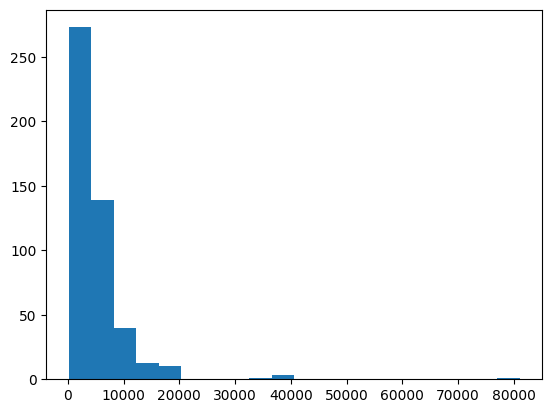

In [60]:
plt.hist(train["ApplicantIncome"], bins=20)

## Trening modeli

### Rank SVM — interpretowalny model ML

### ANN-Ch-Constr. — interpretowalny model ANN-MCDA

### Głęboka sieć neuronowa — model złożony.

## Eksperymenty
Wszystkie prezentowane wartości są do maksymalnie 4 miejsc po przecinku.

### Przedstawienie metryk

- Rank SVM
    - Accuracy
    - F1
    - AUC
- ANN-Ch-Constr.
    - Accuracy
    - F1
    - AUC
- Głęboka sieć neuronowa
    - Accuracy
    - F1
    - AUC


### Przedstawienie modelu
(np funkcje cząstkowe, schemat drzewa ...).


### Interpretacja
- Czy na podstawie uzyskanych parametrów możemy powiedzieć coś o preferencjach
użytkowników?
- Czy są jakieś kryteria, które nie mają żadnego wpływu, czy też mają wpływ decydujący.
- Czy istnieją jakieś progi preferencji?
- Czy istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji?


### Interpretacja techniką Partial Dependence Plot
Wykonaj interpretację modelu korzystając z conajmniej jednej techniki( Global Surrogate,
Partial Dependence Plot Permutation Feature Importance ...)


Dla 3 wybranych wariantów dokonaj wyjaśnienia decyzji.
- Znajdź minimalną zmianę w ocenach tak aby wariant został przypisany do innej klasy.
    – Spróbuj odpowiedzieć na to pytanie w sposób analityczny, opierając się tylko na
wartościach parametrów modelu i wyjaśnij, dlaczego taka zmiana jest minimalna
(bez próbkowania).
    - Wykonaj próbkowanie przestrzeni, nieznacznie zmieniając oceny, tak aby uzyskać
inną klasę. Czy wyniki zgadzają się z przewidywaniami teoretycznymi?
- Dokonaj wyjaśnienia predykcji za pomocą conajmniej jednej techniki (Anchors LIME,
SHAP, ... )


##### Możliwe narzędzia
Lista narzędzi, które zawierają różne techniki wyjaśniania predykcji i interpretacji modelu:
- Shapash
- Alibi
- Explainerdashboard
- DALEX
- eli5
- aix360